### Spatial Interpolation
***
***
Set working directory, load libraries, read in data.

In [1]:
setwd("C:/Users/stein/Dropbox/Studium/7. Semester/BA-Thesis/BA-Thesis_NorthEuraLex")

library(gstat)
library(sf)
library(spData)
library(smacof)
library(terra)
library(tidyverse)
library(tmap)

pmi_dists = read.csv("./language_distances/pmi_dists.csv")
geodata = read_tsv("./data/northeuralex-0.9-language-data.tsv")

Linking to GEOS 3.9.3, GDAL 3.5.2, PROJ 8.2.1; sf_use_s2() is TRUE

To access larger datasets in this package, install the spDataLarge
package with: `install.packages('spDataLarge',
repos='https://nowosad.github.io/drat/', type='source')`

Lade nötiges Paket: plotrix

Lade nötiges Paket: colorspace

Lade nötiges Paket: e1071


Attache Paket: 'smacof'


Das folgende Objekt ist maskiert 'package:base':

    transform


terra 1.6.47


Attache Paket: 'terra'


Das folgende Objekt ist maskiert 'package:e1071':

    interpolate


Das folgende Objekt ist maskiert 'package:colorspace':

    RGB


Das folgende Objekt ist maskiert 'package:plotrix':

    rescale


── Attaching packages ─────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0      ✔ purrr   1.0.1 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.5.0 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ───────────────────────────────────────────────────

***
Use function from the MDS file again and get the projected worldmap.

In [2]:
colour_and_convert = function(fit.mds, range_a, range_b = range_a) {

   mds_data = 
        fit.mds$conf[range_a,] %>%
        # convert matrix containing the coordinates to tibble
        as_tibble() %>%
        # add column with ISO codes
        mutate(iso_code = slice(geodata, range_b)$iso_code) %>%
        # subtract the smallest value (Step 1/2)
        mutate(x = D1 - min(.$D1), y = D2 - min(.$D2), z = D3 - min(.$D3)) %>%
        # divide by maximum value (Step 2/2, all values are between 0 and 1 now))
        mutate(r = x / max(.$x), g = y / max(.$y), b = z / max(.$z)) %>%
        # combine r, g, and b into a color
        mutate(col = rgb(r,g,b)) %>%
        # select the only two relevant columns
        select(iso_code, col, r, g, b)

    coloured_mds = 
        slice(geodata, range_b) %>% 
        select(iso_code, latitude, longitude, name, family, subfamily) %>%
        inner_join(mds_data) %>%
        st_as_sf(coords=c("longitude", "latitude"), crs=4326) %>%
        st_transform("+proj=eqearth lon_0=125")
    
}

In [3]:
# produce an extremely slim polygon that represents the 60° W meridian
meridian_55_west = 
  st_polygon(x = list(rbind(c(-55.0001, 90), # upper left corner of the polygon
                            c(-55, 90), # upper right corner of the polygon
                            c(-55, -90), # lower right corner of the polygon
                            c(-55.0001, -90), # lower left corner of the polygon
                            c(-55.0001, 90)))) %>%
  st_sfc() %>%
  # set the crs of the polygon to the geodetic system for world
  st_set_crs(4326)

library(spData)

# remove everything on the 60° meridian from the world data, effectively cutting all polygons that cross the meridian
world_without_55 = 
  world %>% 
  st_difference(meridian_55_west) %>% 
  st_transform("+proj=eqearth lon_0=125")

Warning message:
"attribute variables are assumed to be spatially constant throughout all geometries"


Get rid of some of the languages that are very far away from other languages.

In [4]:
inds1 = which(geodata$latitude < 37)
inds2 = which(geodata$longitude < -8.1)
inds3 = which(geodata$longitude > 49.50000)

excluded_langs = sort(unique(c(inds1, inds2, inds3)))

Apply MDS on a subset of the PMI-based distance matrix. 

[1] "Stress"


[1] 0.1586023


Call: permtest.smacof(object = fit.pmi, nrep = 100, verbose = FALSE)

SMACOF Permutation Test
Number of objects: 62 
Number of replications (permutations): 100 

Observed stress value: 0.159 
p-value: <0.001 


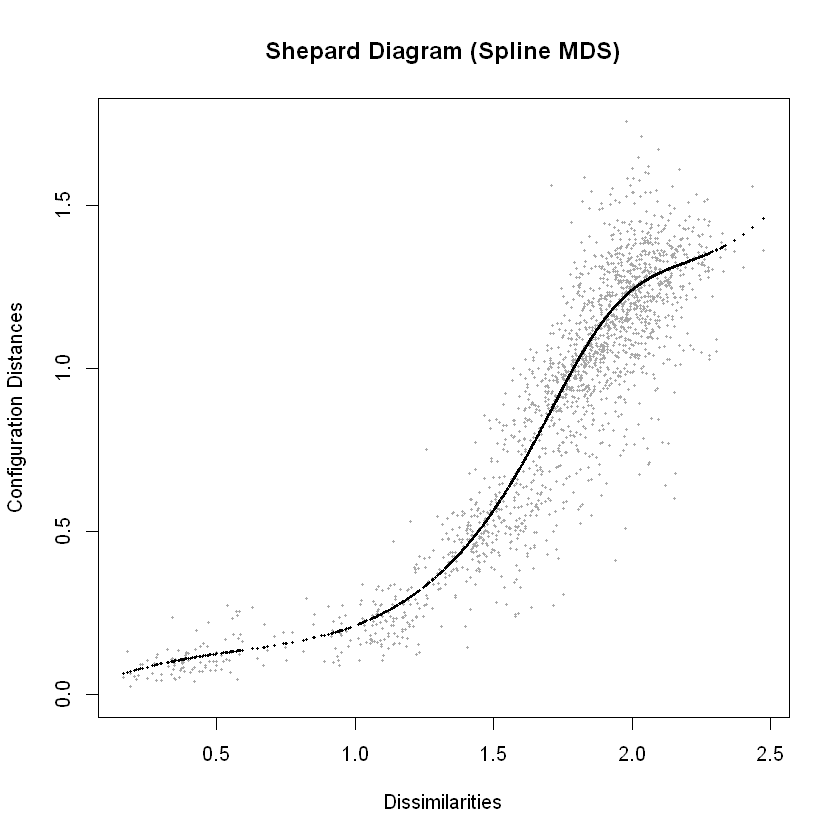

In [5]:
fit.pmi = mds(pmi_dists[-excluded_langs, -excluded_langs], ndim = 3, type = "mspline", 
              spline.degree = 4, spline.intKnots = 4)

print("Stress")
fit.pmi$stress
plot(fit.pmi, plot.type = "Shepard",
main = "Shepard Diagram (Spline MDS)")

res.perm <- permtest(fit.pmi, nrep = 100, verbose = FALSE)
res.perm

Make a map of the languages that are used for the spatial interpolation.

Joining, by = "iso_code"


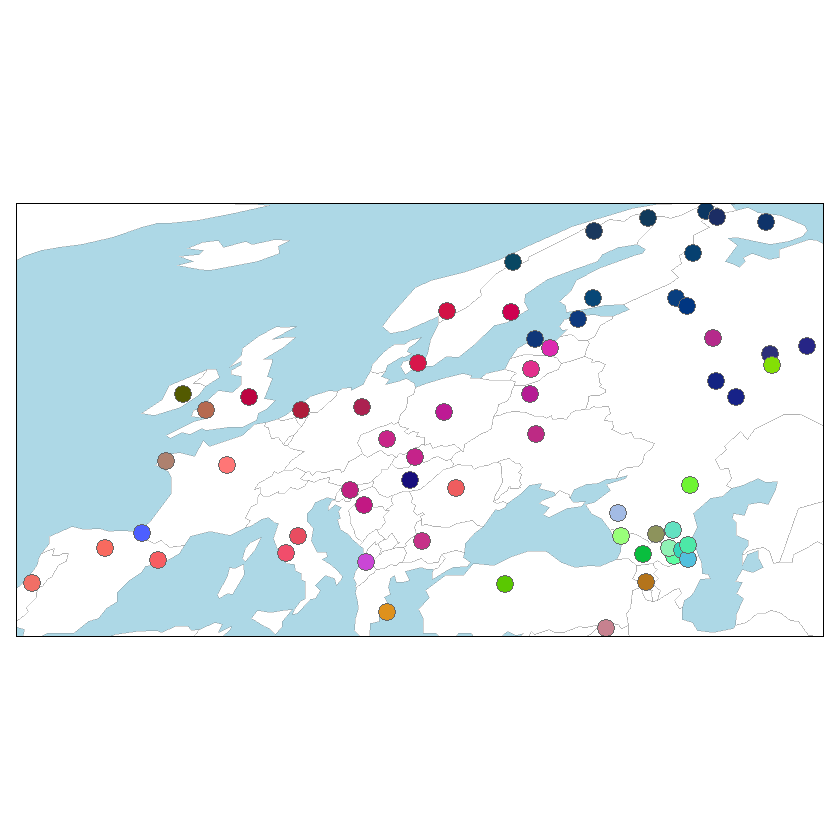

In [8]:
coloured_northeuralex_pmi = colour_and_convert(fit.pmi, 1:62 , range_b = -excluded_langs)

# tmap_save(
coloured_northeuralex_pmi %>%
    tm_shape() +
    tm_symbols(size=0.2) +
    tm_shape(world_without_55) +
    tm_polygons(alpha = 1, col = 'white', border.alpha = 0.3) +
    tm_layout(bg.color = 'lightblue') +
    tm_shape(coloured_northeuralex_pmi) +
    tm_symbols(size=1.0, col="col", border.lwd=1, alpha=1)
# ,filename="./imgs/kriging_langs.png" ,dpi = 600)

Create a grid of the world.

In [10]:
world_grid = 
    coloured_northeuralex_pmi %>% 
    # get the rectangle which contains all of the geodata_sf language points
    st_bbox() %>%
    st_as_sfc() %>%
    # create a grid based on that rectangle
    st_make_grid(
        cellsize = c(10000, 10000),
        what="centers"
    )

Create variograms for each dimension and fit them with a model of choice.

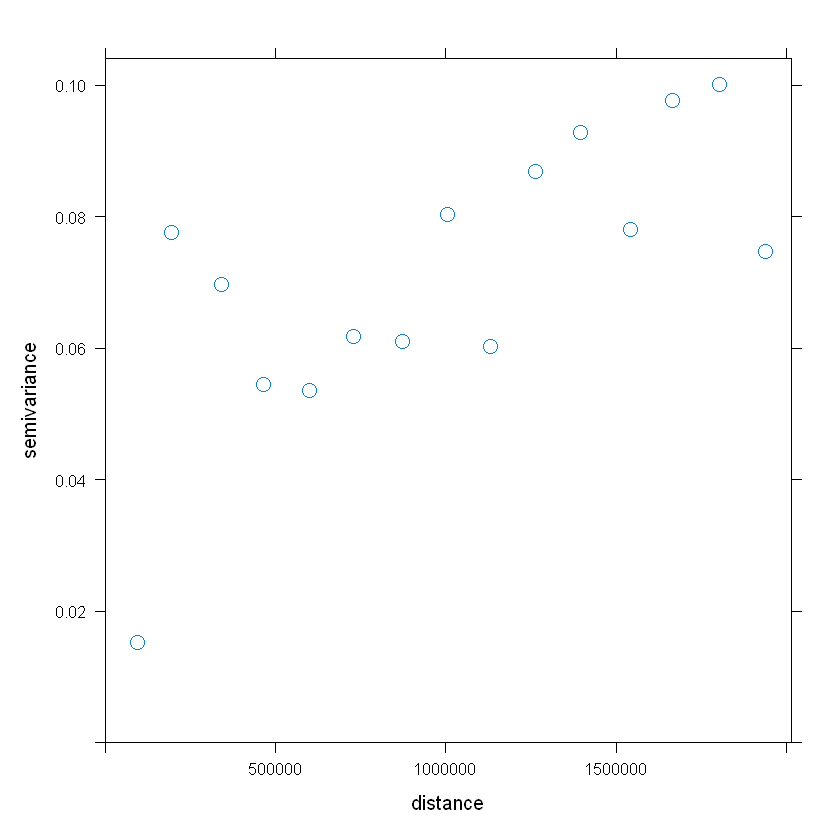

Warning message in fit.variogram(geodata_vgm, model):
"singular model in variogram fit"


[1] "a possible solution MIGHT be to scale semivariances and/or distances"


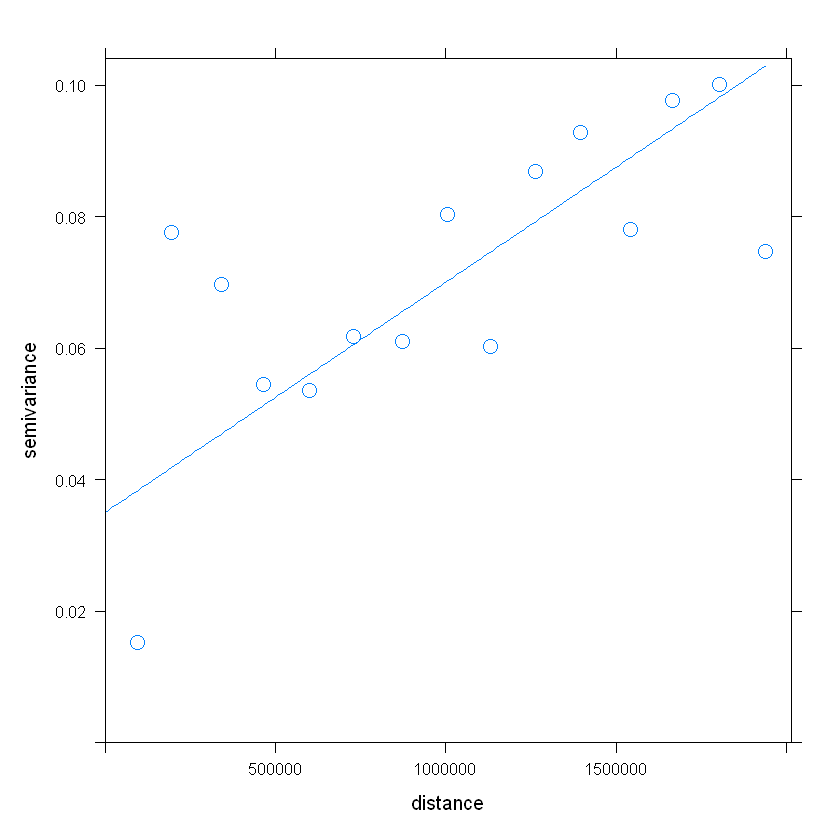

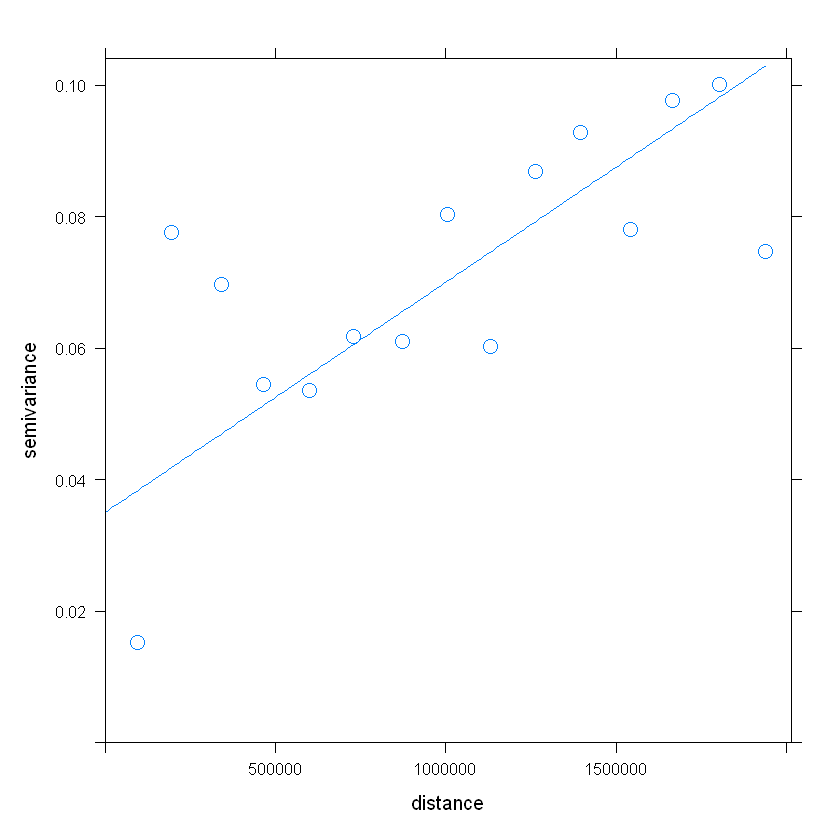

In [15]:
geodata_vgm = variogram(r ~ 1, coloured_northeuralex_pmi, cutoff = 2000000)
# ...and plot it
plot(geodata_vgm, cex = 1.5)
     
model = vgm(nugget = 0.035, psill=0.07 ,"Lin", range = 2000000)
plot(geodata_vgm, model, cex = 1.5, lwd= 1.5)

vgm_fit = fit.variogram(geodata_vgm, model)
# ... and plot it with the variogram
plot(geodata_vgm, vgm_fit, cex = 1.5, lwd= 1.5)

In [17]:
geodata_krigedR = krige(r ~ 1, coloured_northeuralex_pmi, world_grid, model=vgm_fit)

[using ordinary kriging]


In [28]:
krigeR.raster = 
      geodata_krigedR %>%
      cbind(., st_coordinates(.)) %>%
      st_drop_geometry() %>%
      mutate(R = var1.pred) %>%
      dplyr::select(X, Y, R) %>%
      raster::rasterFromXYZ() %>%
      as("SpatRaster")

# filter the raster, so that predictions on the oceans / seas are ignored
filtered_raster = mask(krigeR.raster, vect(world_without_55)) 
# plot the raster
eurasia = st_intersection(world_without_55, st_as_sfc(st_bbox(coloured_northeuralex_pmi)))
png(file="./imgs/first_dimension.png", 5000, 5000, res=600)
plot(filtered_raster, axes=FALSE, legend=T, plg=list(shrink=0.66))
plot(st_geometry(eurasia), add=T, border="brown")
dev.off()
title("First Dimension", line=0.5, cex.main=2.0)

Warning message:
"attribute variables are assumed to be spatially constant throughout all geometries"


png 
  2

ERROR: Error in title("First Dimension", line = 0.5, cex.main = 2): plot.new has not been called yet


png 
  2

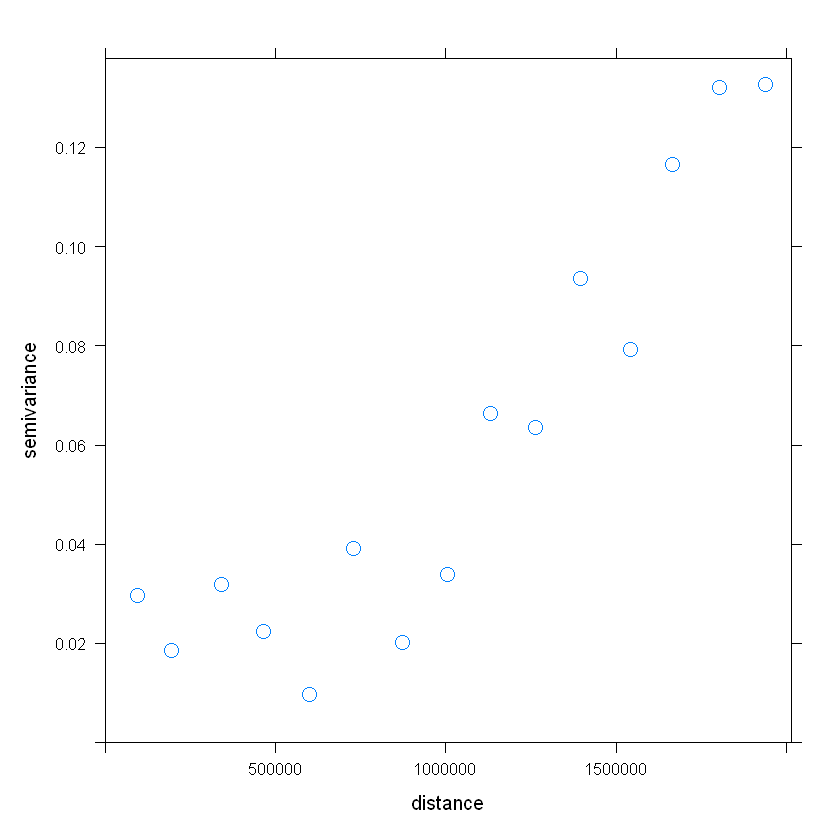

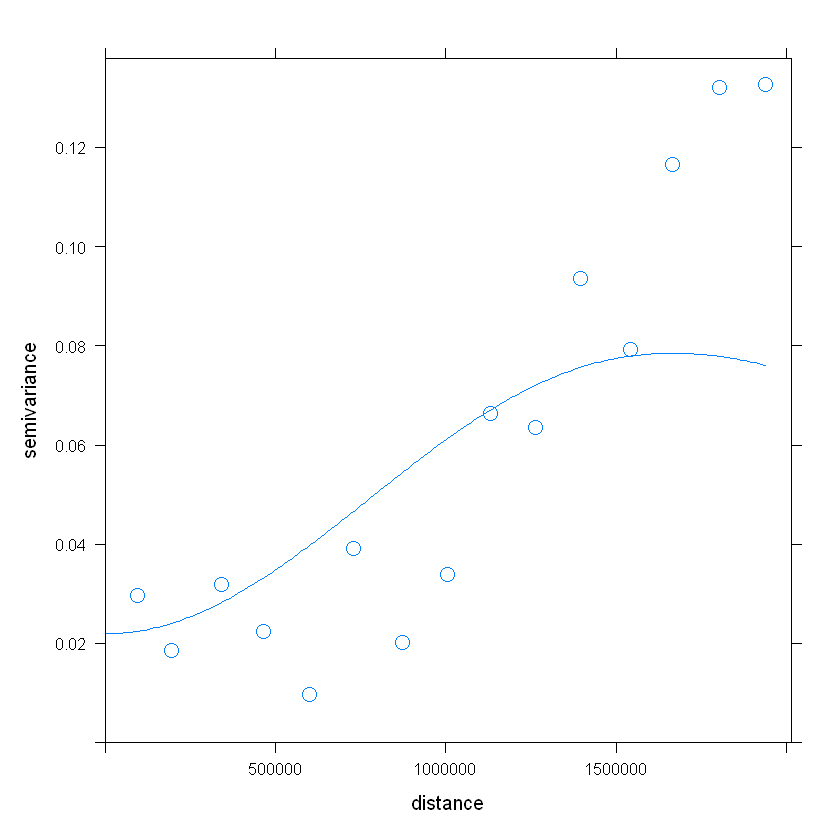

In [20]:
geodata_vgm = variogram(g ~ 1, coloured_northeuralex_pmi, cutoff=2000000)
# ...and plot it

plot(geodata_vgm, cex = 1.5)

png(file="./imgs/variogram_fitted.png", 5000, 5000, res=600)
model = vgm(nugget = 0.025, psill=0.7, "Hol", range=2000000)
plot(geodata_vgm, model, cex = 1.5, lwd= 1.5)
dev.off()

vgm_fit = fit.variogram(geodata_vgm, model)
# ... and plot it with the variogram
plot(geodata_vgm, vgm_fit, cex = 1.5, lwd= 1.5)

In [21]:
geodata_krigedG = krige(g ~ 1, coloured_northeuralex_pmi, world_grid, model=vgm_fit)

[using ordinary kriging]


In [27]:
krigeG.raster = 
      geodata_krigedG %>%
      cbind(., st_coordinates(.)) %>%
      st_drop_geometry() %>%
      mutate(G = var1.pred) %>%
      dplyr::select(X, Y, G) %>%
      raster::rasterFromXYZ() %>%
      as("SpatRaster")

# filter the raster, so that predictions on the oceans / seas are ignored
filtered_raster = mask(krigeG.raster, vect(world_without_55)) 
# plot the raster
eurasia = st_intersection(world_without_55, st_as_sfc(st_bbox(coloured_northeuralex_pmi)))
png(file="./imgs/second_dimension.png", 5000, 5000, res=600)
plot(filtered_raster, axes=FALSE, legend=T, plg=list(shrink=0.66))
plot(st_geometry(eurasia), add=T, border="brown")
dev.off()
title("Second Dimension", line=0.5, cex.main=2.0)

Warning message:
"attribute variables are assumed to be spatially constant throughout all geometries"


png 
  2

ERROR: Error in title("Second Dimension", line = 0.5, cex.main = 2): plot.new has not been called yet


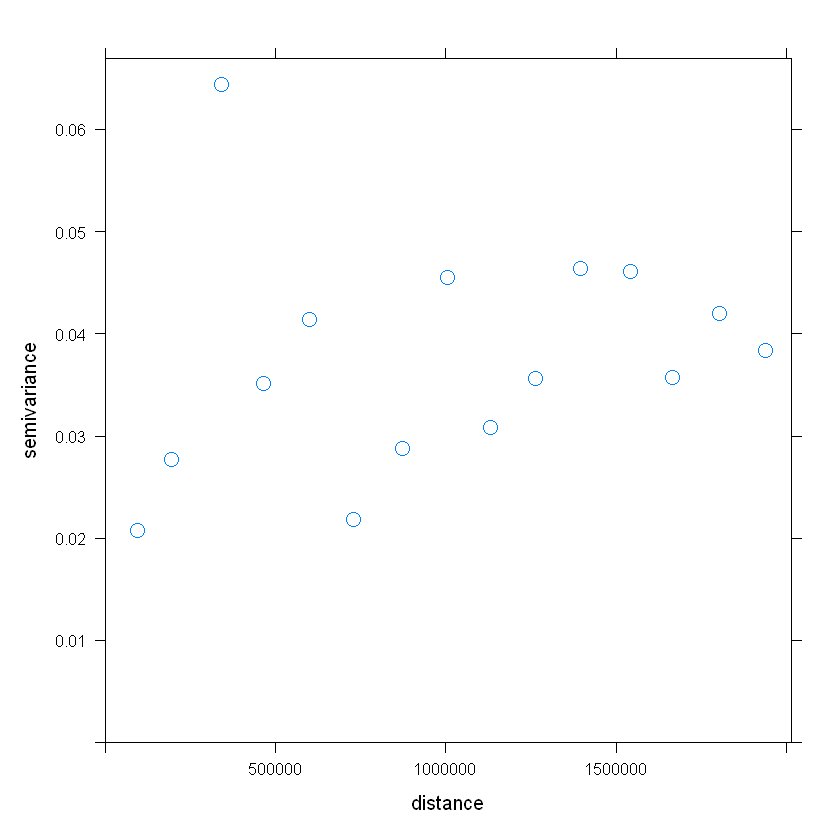

Warning message in fit.variogram(geodata_vgm, model):
"singular model in variogram fit"


[1] "a possible solution MIGHT be to scale semivariances and/or distances"


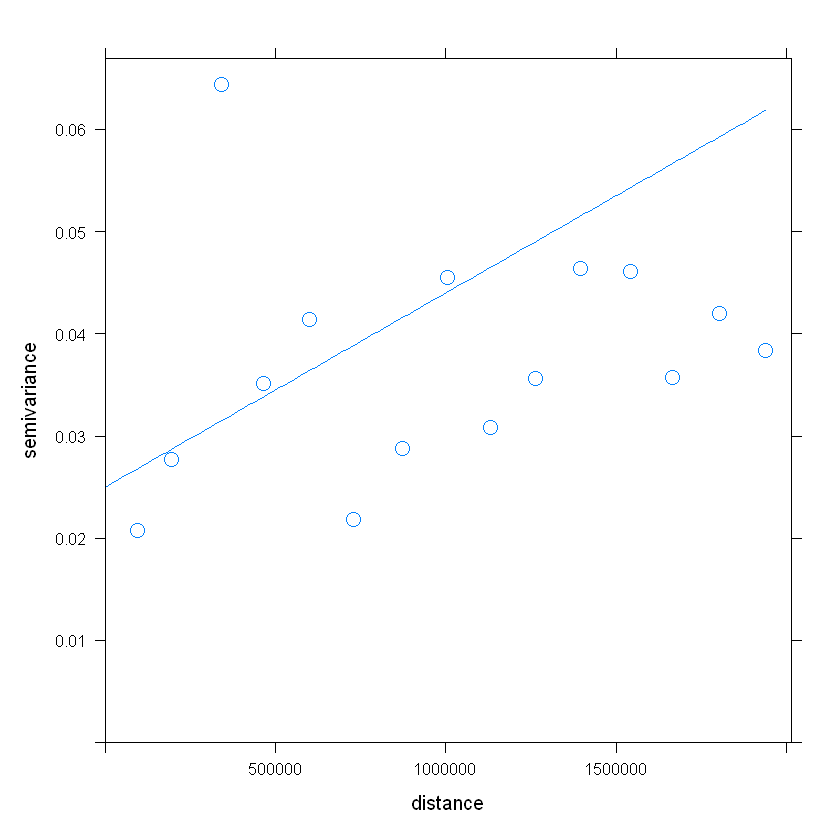

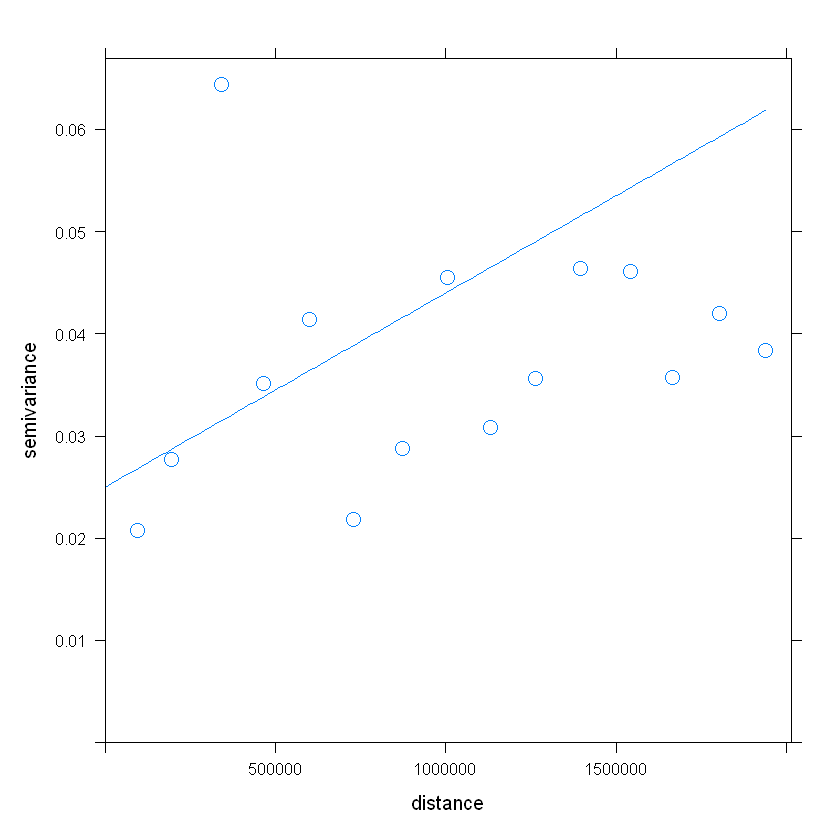

In [23]:
geodata_vgm = variogram(b ~ 1, coloured_northeuralex_pmi, cutoff=2000000)
# ...and plot it
plot(geodata_vgm, cex = 1.5)

model = vgm(nugget = 0.025, psill=0.038, "Lin", range=2000000)
plot(geodata_vgm, model, cex = 1.5, lwd= 1.5)

vgm_fit = fit.variogram(geodata_vgm, model)
# ... and plot it with the variogram
plot(geodata_vgm, vgm_fit, cex = 1.5, lwd= 1.5)

In [24]:
geodata_krigedB = krige(b ~ 1, coloured_northeuralex_pmi, world_grid, model=vgm_fit)

[using ordinary kriging]


In [26]:
krigeB.raster = 
      geodata_krigedB %>%
      cbind(., st_coordinates(.)) %>%
      st_drop_geometry() %>%
      mutate(B = var1.pred) %>%
      dplyr::select(X, Y, B) %>%
      raster::rasterFromXYZ() %>%
      as("SpatRaster")

# filter the raster, so that predictions on the oceans / seas are ignored
filtered_raster = mask(krigeB.raster, vect(world_without_55)) 
# plot the raster
eurasia = st_intersection(world_without_55, st_as_sfc(st_bbox(coloured_northeuralex_pmi)))
plot(filtered_raster, axes=FALSE, legend=T, plg=list(shrink=0.66))
plot(st_geometry(eurasia), add=T, border="brown")
title("Third Dimension", line=0.5, cex.main=2.0)

Warning message:
"attribute variables are assumed to be spatially constant throughout all geometries"


png 
  2

ERROR: Error in title("Third Dimension", line = 0.5, cex.main = 2): plot.new has not been called yet


In [114]:
# scale the values to be between 0 and 1
krigeR.raster = krigeR.raster - minmax(krigeR.raster)[1]
krigeR.raster = krigeR.raster / minmax(krigeR.raster)[2]

# repeat for 2nd dimension
krigeG.raster = krigeG.raster - minmax(krigeG.raster)[1]
krigeG.raster = krigeG.raster / minmax(krigeG.raster)[2]

# repeat for 3rd dimension
krigeB.raster = krigeB.raster - minmax(krigeB.raster)[1]
krigeB.raster = krigeB.raster / minmax(krigeB.raster)[2]

In [115]:
# adapting the plot window for the last two plots
krigeRGB.raster = c(krigeR.raster, krigeG.raster, krigeB.raster)
filtered_raster = mask(krigeRGB.raster, vect(world_without_55)) 
png(file="./imgs/kriging_map2.png", 5000, 5000, res=600)
plotRGB(filtered_raster, axes=T, scale=1, colNA="lightblue", alpha=1, bgalpha=200)
plot(st_geometry(eurasia), add=T, border="black")
dev.off()

pdf 
  2

In [134]:
print(citation("gstat"), bibtex=T)


To cite package gstat in publications use:

  Pebesma, E.J., 2004. Multivariable geostatistics in S: the gstat
  package. Computers & Geosciences, 30: 683-691.

Ein BibTeX-Eintrag für LaTeX-Benutzer ist

  @Article{,
    title = {Multivariable geostatistics in {S}: the gstat package},
    author = {Edzer J. Pebesma},
    journal = {Computers & Geosciences},
    year = {2004},
    volume = {30},
    pages = {683-691},
  }

  Benedikt Gräler, Edzer Pebesma and Gerard Heuvelink, 2016.
  Spatio-Temporal Interpolation using gstat.  The R Journal 8(1),
  204-218

Ein BibTeX-Eintrag für LaTeX-Benutzer ist

  @Article{,
    title = {Spatio-Temporal Interpolation using gstat},
    author = {Benedikt Gräler and Edzer Pebesma and Gerard Heuvelink},
    year = {2016},
    journal = {The R Journal},
    volume = {8},
    issue = {1},
    pages = {204-218},
    url = {https://journal.r-project.org/archive/2016/RJ-2016-014/index.html},
  }

